In [3]:
import math
import pandas as pd
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np

In [4]:
bts = pd.read_csv('../data/bts.csv')
meds_train_alunos = pd.read_csv('../data/meds_train_alunos.csv')

In [5]:
X = meds_train_alunos[['rssi_1_1', 'rssi_1_2', 'rssi_1_3', 'rssi_2_1', 'rssi_2_2', 'rssi_2_3', 'rssi_3_1', 'rssi_3_2', 'rssi_3_3']]

y = meds_train_alunos[['lat', 'lon']]

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [7]:
k = 3  # Número de vizinhos
knn = KNeighborsRegressor(n_neighbors=k)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

#### Dataframe com as informações de erros

In [16]:
df_with_error_info = y_test.copy()
df_with_error_info['lat_pred'] = [lat for lat, _ in y_pred]
df_with_error_info['lon_pred'] = [lon for _, lon in y_pred]

df_with_error_info['lat_diff'] = df_with_error_info['lat'] - df_with_error_info['lat_pred']
df_with_error_info['lon_diff'] = df_with_error_info['lon'] - df_with_error_info['lon_pred']

In [20]:
one_degree = 30.87
one_kilometer = 1000

df_with_error_info['lat_diff_meters'] = df_with_error_info['lat_diff'] * one_degree * one_kilometer
df_with_error_info['lon_diff_meters'] = df_with_error_info['lon_diff'] * one_degree * one_kilometer

In [38]:
df_with_error_info['diff_meters'] = np.sqrt(df_with_error_info['lat_diff_meters']**2 + df_with_error_info['lon_diff_meters']**2)

## Resultados

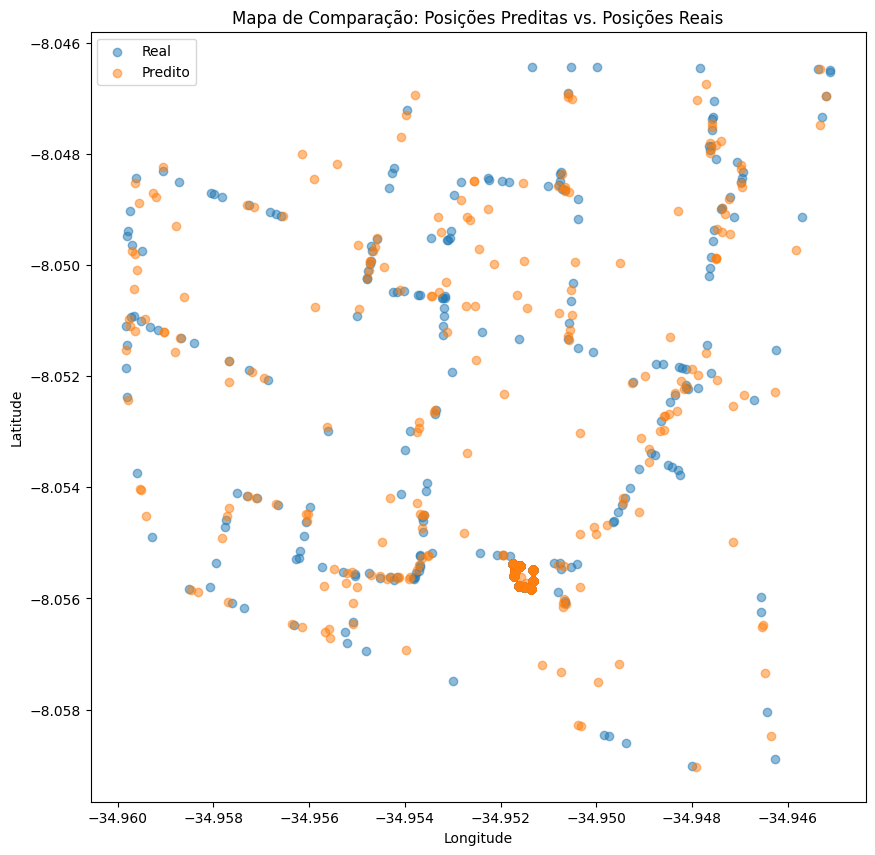

In [23]:
y_pred_array = np.array(y_pred)

plt.figure(figsize=(10, 10))
plt.scatter(y_test['lon'], y_test['lat'], label='Real', alpha=0.5)
plt.scatter(y_pred_array[:, 1], y_pred_array[:, 0], label='Predito', alpha=0.5)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Posições Preditas vs. Posições Reais')
plt.legend()
plt.show()

In [42]:
mean_diff_meters = df_with_error_info['diff_meters'].mean()
min_diff_meters = df_with_error_info['diff_meters'].min()
max_diff_meters = df_with_error_info['diff_meters'].max()
std_diff_meters = df_with_error_info['diff_meters'].std()

print(f"Média de erro: {mean_diff_meters:.2f} metros")
print(f"Mínimo de erro: {min_diff_meters:.2f} metros")
print(f"Máximo de erro: {max_diff_meters:.2f} metros")
print(f"Desvio padrão dos erros: {std_diff_meters:.2f} metros")

Média de erro: 7.89 metros
Mínimo de erro: 0.00 metros
Máximo de erro: 369.51 metros
Desvio padrão dos erros: 27.40 metros


#### Gráficos dos erros

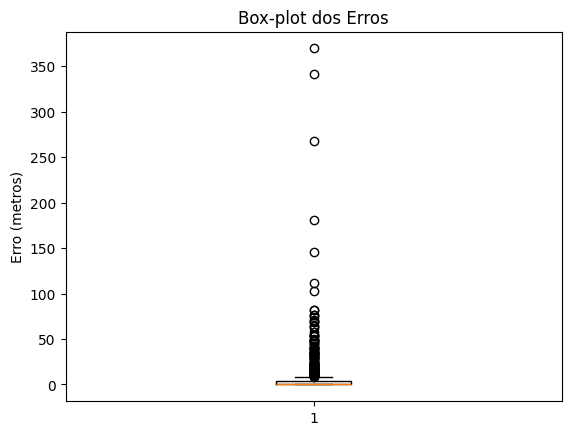

In [25]:
# Histograma e Box-Plot dos Erros
plt.boxplot(df_with_error_info['diff_meters'])
plt.ylabel('Erro (metros)')
plt.title('Box-plot dos Erros')
plt.show()

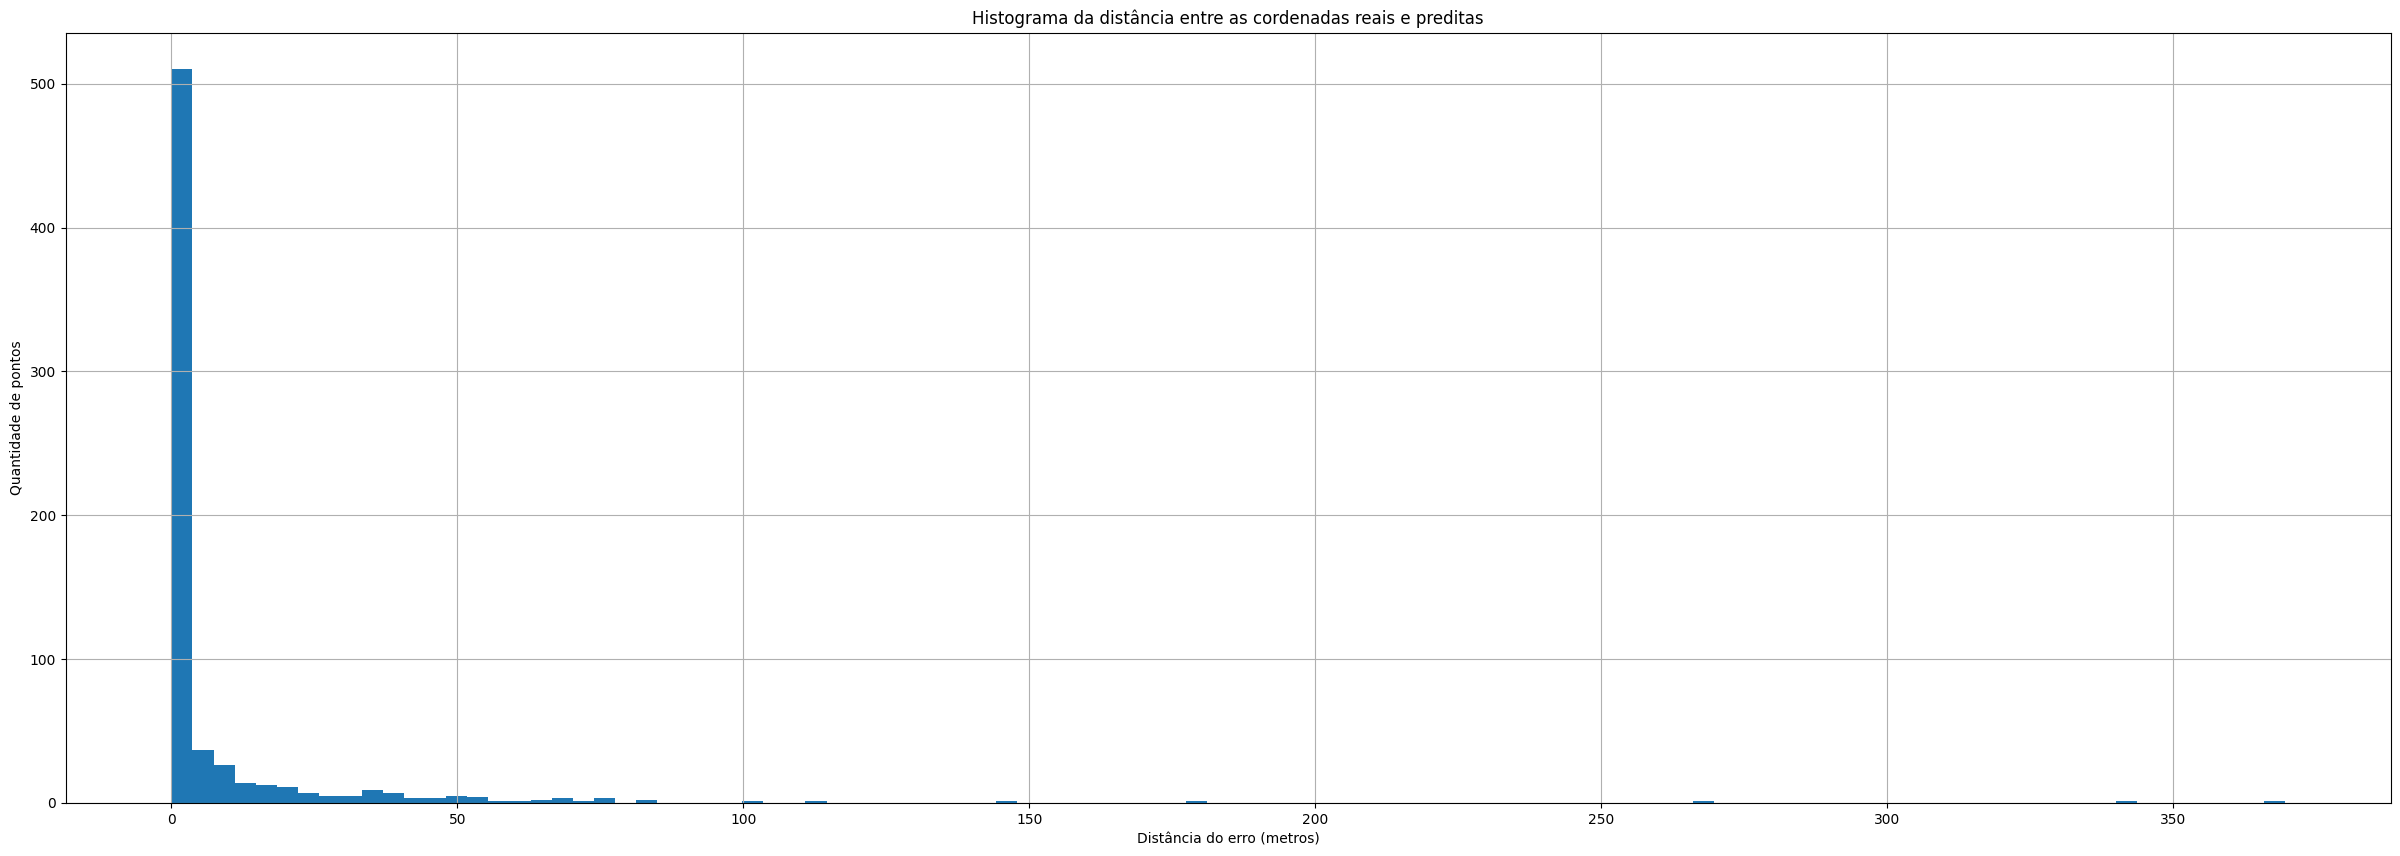

In [37]:
plt.figure(figsize=(30, 10))
plt.hist(df_with_error_info['diff_meters'], bins=100)

plt.xlabel('Distância do erro (metros)')
plt.ylabel('Quantidade de pontos')
plt.title('Histograma da distância entre as cordenadas reais e preditas')

plt.grid(True)
plt.show()

## Gerar submit file

In [30]:
meds_test = pd.read_csv('../data/meds_test_alunos.csv')

In [35]:
X_test = meds_test[['rssi_1_1', 'rssi_1_2', 'rssi_1_3', 'rssi_2_1', 'rssi_2_2', 'rssi_2_3', 'rssi_3_1', 'rssi_3_2', 'rssi_3_3']]

y_pred_test = knn.predict(X_test)

In [36]:
submit_df = pd.DataFrame({'ponto_id': meds_test['ponto_id'], 'lat_pred': y_pred_test[:, 0], 'lon_pred': y_pred_test[:, 1]})
submit_df.to_csv('../submit_files/knn_submit_alunos.csv', index=False)